# Cuaderno de presentación prueba NLP Davivienda

En este cuaderno se hace una breve descripción de aspectos relevantes obtenidos en los tweets.

In [2]:
#!pip install spacy
#!python -m spacy download es_core_news_sm
#!pip install transformers
#!pip install tensorflow
#!pip install bs4
#!pip install networkx

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import plotly.express as px
import plotly.graph_objects as go

import spacy
import es_core_news_sm
nlp=spacy.load("es_core_news_sm")
from spacy import displacy

import urllib
from bs4 import BeautifulSoup

import transformers
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, BertConfig


import networkx as nx
from networkx.algorithms import community


In [4]:
## Lectura de datos

df_tweets = pd.read_csv("../Datos/davivienda_tweets.csv")
df_tweets.head()

,Unnamed: 0,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,0,Andrés Langebaek,@ALangebaek,2021-12-01T20:43:12.000Z,Andrés Langebaek\n@ALangebaek\n·\n1 dic.,La confianza se afectó. El indicador de confia...,NaN,1.0,7,19,['https://pbs.twimg.com/media/FFjL57eXMAISBnk?...,https://twitter.com/ALangebaek/status/14661458...
1,1,Plaza Futura,@plaza_futura,2021-12-01T21:18:10.000Z,Plaza Futura\n@plaza_futura\n·\n1 dic.,Buscamos la accesibilidad y mejor atención en ...,✅ ✅ ✅ ✅ ✅,NaN,NaN,NaN,['https://pbs.twimg.com/ext_tw_video_thumb/146...,https://twitter.com/plaza_futura/status/146615...
2,2,Julián Martinez,@JulianM998,2021-12-01T22:49:11.000Z,Julián Martinez\n@JulianM998\n·\n1 dic.,Señores \n@Davivienda\n no he podido ingresar ...,NaN,1.0,NaN,1,[],https://twitter.com/JulianM998/status/14661775...
3,3,Ferchis.,@fergomezr28,2021-12-01T12:29:07.000Z,Ferchis.\n@fergomezr28\n·\n1 dic.,Llevo toda una semana sufriendo intento de hur...,NaN,2.0,1,2,[],https://twitter.com/fergomezr28/status/1466021...
4,4,MirandaL2,@MirandaSuspLo,2021-12-01T20:52:36.000Z,MirandaL2\n@MirandaSuspLo\n·\n1 dic.,Hemos retrocedido tanto en este país con este ...,NaN,3.0,NaN,8,[],https://twitter.com/MirandaSuspLo/status/14661...


In [42]:
## Limpieza de datos
## Iniciamos extrayendo caracteres especiales (\n)

df_tweets['Embedded_text_1'] = df_tweets['Embedded_text'].apply(lambda x: re.sub(r'\n[ 0-9]*', ' ', x))

## Luego extraemos los links
df_tweets['links'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'http\S+', x))
links_title=[]
for i in df_tweets['links']:
    if len(i)==0:
        links_title.append("")
    else:
        lista_i=[]
        for k in i:
            #print(k)
            try:
                html_page = urllib.request.urlopen(k)
                soup = BeautifulSoup(html_page)
                lista_i.append(soup.title.string)
            except:
               new_k=k.replace("https://","")
               new_k=new_k.replace("http://","")
               new_k=re.sub(r'\.[A-Za-z\.]*', '', new_k)
               new_k=re.sub(r'\/.*', '', new_k)
               lista_i.append(new_k)
        links_title.append(lista_i)

df_tweets['links_title']=links_title
df_tweets['conteo_links'] = df_tweets['links'].apply(lambda x: len(x))
df_tweets['Embedded_text_1'] = df_tweets['Embedded_text_1'].apply(lambda x: re.sub(r'http\S+', 'Link_aqui', x))

## Luego extraemos los hashtags
df_tweets['hashtags'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'#\S+', x))
df_tweets['conteo_hashtags'] = df_tweets['hashtags'].apply(lambda x: len(x))

## Luego extraemos los menciones
df_tweets['menciones'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'@\S+', x))
df_tweets['menciones'] = [[re.sub("[^0-9A-Za-z\_\-]","",men.lower()) for men in k] for k in df_tweets['menciones']]
df_tweets['conteo_menciones'] = df_tweets['menciones'].apply(lambda x: len(x))


In [43]:
## Luego extraemos los emojis
df_tweets['emojis'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'\\u\S+', x))
df_tweets['conteo_emojis'] = df_tweets['emojis'].apply(lambda x: len(x))

## Luego extraemos los RT
df_tweets['RT'] = df_tweets['Embedded_text_1'].apply(lambda x: re.findall(r'RT', x))
df_tweets['conteo_RT'] = df_tweets['RT'].apply(lambda x: len(x))



In [44]:
## Análisis de sentimientos

## Cargamos el modelo de sentimientos

from transformers import pipeline
nlp_sentiment = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

## Aplicamos el modelo a los tweets

df_tweets['sentiment'] = df_tweets['Embedded_text_1'].apply(lambda x: nlp_sentiment(x)[0]['label'])
df_tweets['score'] = df_tweets['Embedded_text_1'].apply(lambda x: nlp_sentiment(x)[0]['score'])


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
df_tweets['sentiment'].value_counts()

1 star     1250
5 stars     314
4 stars     152
3 stars      51
2 stars      44
Name: sentiment, dtype: int64

In [ ]:
df_tweets['score'].describe()

count    1811.000000
mean        0.546778
std         0.188656
min         0.219787
25%         0.389547
50%         0.513138
75%         0.697739
max         0.971901
Name: score, dtype: float64

In [ ]:
## Análisis de entidades

## Cargamos el modelo de entidades

nlp_entidades = pipeline("ner", model="dslim/bert-base-NER")

## Aplicamos el modelo a los tweets

df_tweets['entidades'] = df_tweets['Embedded_text_1'].apply(lambda x: nlp_entidades(x))


Some layers from the model checkpoint at dslim/bert-base-NER were not used when initializing TFBertForTokenClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForTokenClassification were initialized from the model checkpoint at dslim/bert-base-NER.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForTokenClassification for predictions without further training.


In [ ]:
df_tweets['menciones']

0                               []
1                               []
2                    [@davivienda]
3       [@davivienda, @davivienda]
4                    [@davivienda]
                   ...            
1806                [@jaimemolina]
1807                   [@josefe71]
1808                  [@gleniiaaa]
1809                  [@diegoruix]
1810                  [@diegoruix]
Name: menciones, Length: 1811, dtype: object

In [ ]:
## Creamos redes para identificar relaciones entre usuarios. Em pezamos por la mención de usuarios.
list_df=[]
for i in range(len(df_tweets)):
    for j in df_tweets['menciones'][i]:
            df_edges_mencion_temp=pd.DataFrame(data={'Source':[df_tweets['UserName'][i]],'Target':[j],'Weight':[1],'Type':['Mencion']})
            list_df.append(df_edges_mencion_temp)
df_edges_menciones=pd.concat(list_df)
df_edges_menciones=df_edges_menciones.groupby(['Source','Target','Type']).sum().reset_index()



In [ ]:
df_edges_menciones

,Source,Target,Type,Weight
0,@04Elisabeth,@asnasalvaje,Mencion,1
1,@04Elisabeth,@davivienda,Mencion,4
2,@04Elisabeth,"@davivienda,",Mencion,1
3,@04Elisabeth,@sfcsupervisor,Mencion,1
4,@04Elisabeth,@sicsuper,Mencion,1
...,...,...,...,...
2382,H@ner,@bancolombia,Mencion,1
2383,H@ner,@davivienda,Mencion,1
2384,Karen-aleja-287@hotmail.com,@davivienda,Mencion,1
2385,Profe de Llantera (Wilbur bloqueado por @ca_ac...,@fervarelahn,Mencion,1


In [27]:
## Seguimos por la co ocurrencia en tweets
df_edges_menciones=pd.DataFrame(columns=['Source','Target','Weight','Type'])
list_source=[]
list_target=[]
list_weight=[]
list_type=[]
for i in df_tweets['menciones']:
    if len(i)>0:
        n=len(i)
        for k in range(n-1):
            for j in range(k+1,n):
                if i[k]!=i[j]:
                    list_source.append(i[k])
                    list_target.append(i[j])
                    list_weight.append(1)
                    list_type.append("undirected")
df_edges_menciones['Source']=list_source
df_edges_menciones['Target']=list_target
df_edges_menciones['Weight']=list_weight
df_edges_menciones['Type']=list_type
df_edges_menciones=df_edges.groupby(['Source','Target','Type']).sum().reset_index()

df_edges_menciones.to_csv("../Datos/relacion_menciones.csv",index=False)

df_users_menciones=pd.DataFrame(columns=['Id','Label','Weight','Type'])
list_id=[]
list_label=[]
list_weight=[]
list_type=[]
for i in df_tweets['menciones']:
    if len(i)>0:
        for k in i:
            list_id.append(k)
            list_label.append(k)
            list_weight.append(1)
            list_type.append("Undirected")
df_users_menciones['Id']=list_id
df_users_menciones['Label']=list_label
df_users_menciones['Weight']=list_weight
df_users_menciones['Type']=list_type
df_users_menciones=df_users_menciones.groupby(['Id','Label','Type']).sum().reset_index()

df_users_menciones.to_csv("../Datos/usuarios_menciones.csv",index=False)



In [24]:
## Veamos las relaciones de usuarios en mapas de calor

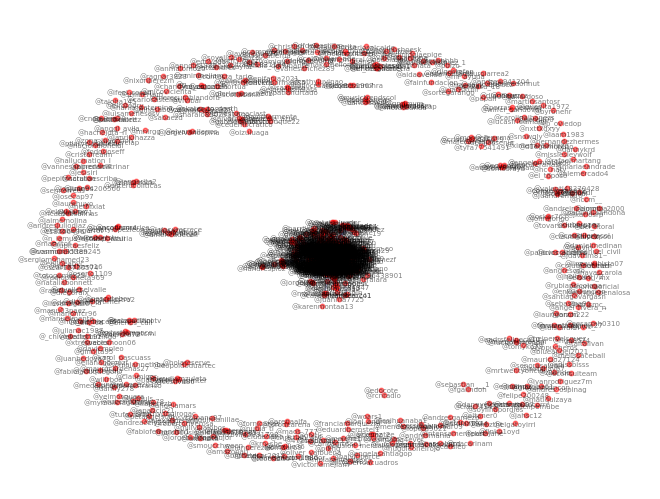

In [28]:
### Pintamos las redes

nodes=df_users_graph[['Id','Label']]
edges=df_edges[['Source','Target','Weight']]
G=nx.from_pandas_edgelist(edges, 'Source', 'Target', edge_attr=True, create_using=nx.Graph())
G.add_nodes_from(nodes['Id'].values)
nx.draw(G, with_labels=True, node_size=10, font_size=5, node_color='red', edge_color='blue', width=0.1, alpha=0.5, arrowsize=1, arrowstyle='->', arrows=True)

